In [1]:
import pandas as pd
import numpy as np
import json
import os
import sys
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = "notebook"

path_root = "D:/Documentos/Erik/TDR/TDR-Forex/"
sys.path.append(path_root)
from utils.strategies import save_strategy_parameters, load_strategy_parameters, get_strategy, preparing_data_backtest, plot_signal

In [2]:
# Guardem els paràmetres fixos de les estratègies
save_strategy_parameters(path_root)

# Estratègies H1

### Estratègia mitjanes

In [7]:
symbol = "EURUSD"; MagicNumber = 2006; realtime = True
strategy_params = load_strategy_parameters(MagicNumber, path_root)
print("PARÀMETRES DEL SISTEMA:")
print(json.dumps(strategy_params, indent=2, ensure_ascii=False))
data = get_strategy(symbol, MagicNumber, path_root, realtime)
data

PARÀMETRES DEL SISTEMA:
{
  "Name": "Mitjanes",
  "TimeFrame": "H1",
  "NBars": 200,
  "DynamicLotSize": true,
  "EquityPercent": 2.5,
  "FixedLotSize": 0.1,
  "MaxOpenTrades": 1,
  "MaxMinutesOpenTrades": 720,
  "MinBetweenTrades": 60,
  "TP_short": 25,
  "TP_long": 25,
  "SL_long": 100,
  "SL_short": 100
}


,time,signal,cond_close_long,cond_close_short,open,high,low,close,ema18,ema30,ema200
0,2025-08-25 15:00:00,0.0,0.0,1.0,1.17021,1.17029,1.16933,1.16973,1.169467,1.168406,1.166458


PARÀMETRES DEL SISTEMA:
{
  "Name": "Mitjanes",
  "TimeFrame": "H1",
  "NBars": 200,
  "DynamicLotSize": true,
  "EquityPercent": 2.5,
  "FixedLotSize": 0.1,
  "MaxOpenTrades": 1,
  "MaxMinutesOpenTrades": 720,
  "MinBetweenTrades": 60,
  "TP_short": 25,
  "TP_long": 25,
  "SL_long": 100,
  "SL_short": 100
}
Ordres de compra: 810
Ordres de venda: 809
Ratio compra/venda: 1.00


,time,signal,cond_close_long,cond_close_short,open,high,low,close,ema18,ema30,ema200
159210,2025-08-22 17:00:00,0.0,1.0,0.0,1.15996,1.17194,1.15996,1.17176,1.161511,1.161705,1.164444
159211,2025-08-22 18:00:00,0.0,1.0,0.0,1.17177,1.17316,1.17127,1.17149,1.162562,1.162337,1.164515


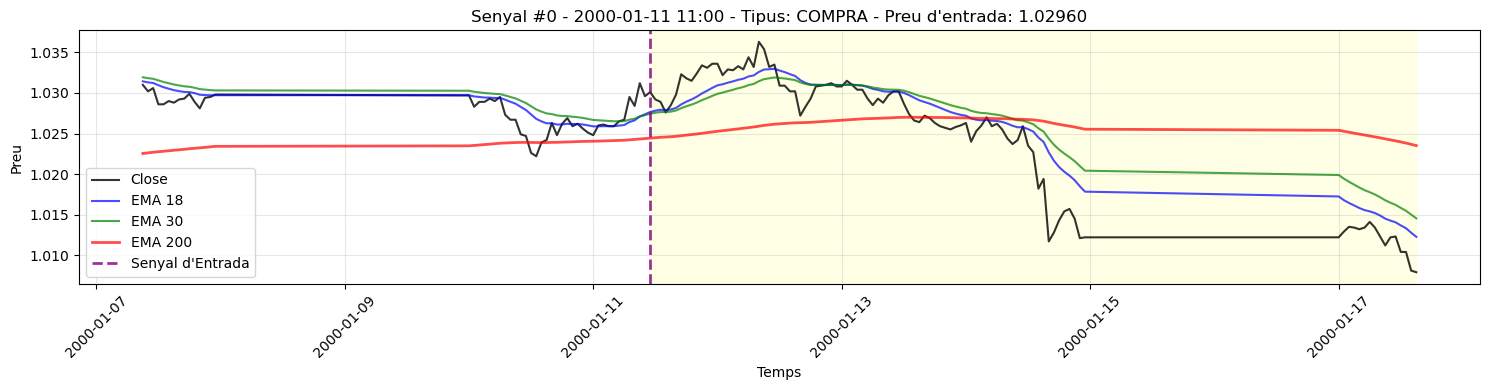

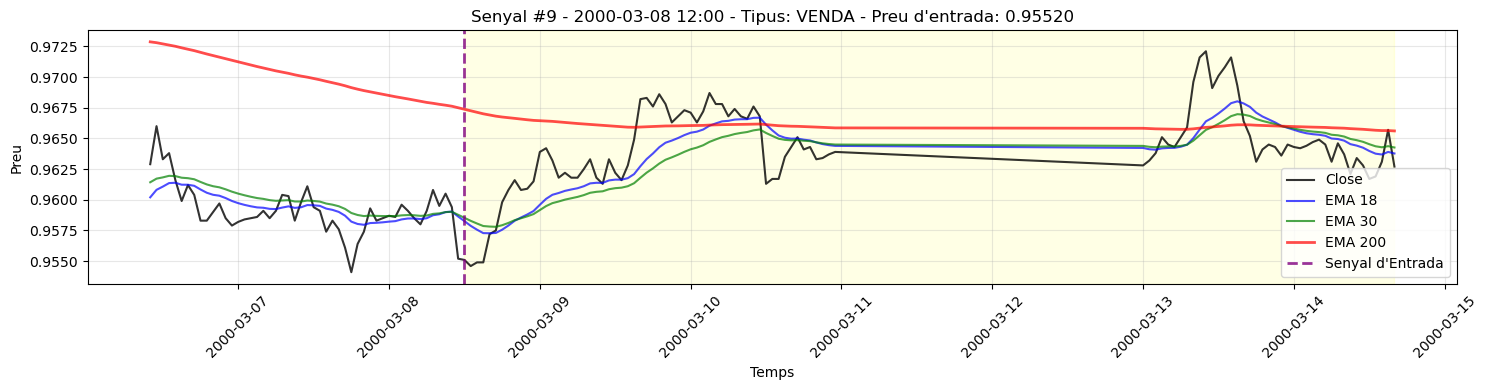

In [3]:
symbol = "EURUSD"; MagicNumber = 2006; realtime = False
strategy_params = load_strategy_parameters(MagicNumber, path_root)
print("PARÀMETRES DEL SISTEMA:")
print(json.dumps(strategy_params, indent=2, ensure_ascii=False))
data = get_strategy(symbol, MagicNumber, path_root, realtime)
display(data.tail(2))
for signal_index in [0,9]:
    plot_signal(data, signal_index, bars_left=50, bars_right=100)

# Estratègies M1

## Estratègia mitjanes

In [6]:
symbol = "EURUSD"; MagicNumber = 1006; realtime = True
strategy_params = load_strategy_parameters(MagicNumber, path_root)
print("PARÀMETRES DEL SISTEMA:")
print(json.dumps(strategy_params, indent=2, ensure_ascii=False))
data = get_strategy(symbol, MagicNumber, path_root, realtime)
data

PARÀMETRES DEL SISTEMA:
{
  "Name": "Mitjanes",
  "TimeFrame": "M1",
  "NBars": 200,
  "DynamicLotSize": true,
  "EquityPercent": 2.5,
  "FixedLotSize": 0.1,
  "MaxOpenTrades": 1,
  "MaxMinutesOpenTrades": 720,
  "MinBetweenTrades": 60,
  "TP_short": 25,
  "TP_long": 25,
  "SL_long": 100,
  "SL_short": 100
}


,time,signal,cond_close_long,cond_close_short,open,high,low,close,ema18,ema30,ema200
0,2025-08-25 15:42:00,0.0,0.0,1.0,1.16966,1.16977,1.16965,1.16973,1.169641,1.169628,1.169491


PARÀMETRES DEL SISTEMA:
{
  "Name": "Mitjanes",
  "TimeFrame": "M1",
  "NBars": 200,
  "DynamicLotSize": true,
  "EquityPercent": 2.5,
  "FixedLotSize": 0.1,
  "MaxOpenTrades": 1,
  "MaxMinutesOpenTrades": 720,
  "MinBetweenTrades": 60,
  "TP_short": 25,
  "TP_long": 25,
  "SL_long": 100,
  "SL_short": 100
}
Ordres de compra: 56610
Ordres de venda: 55258
Ratio compra/venda: 1.02


,time,signal,cond_close_long,cond_close_short,open,high,low,close,ema18,ema30,ema200
9347232,2025-08-22 18:41:00,0.0,0.0,1.0,1.17196,1.17197,1.17157,1.17162,1.172086,1.172078,1.167240
9347233,2025-08-22 18:42:00,0.0,0.0,1.0,1.17163,1.17174,1.17160,1.17162,1.172037,1.172049,1.167284


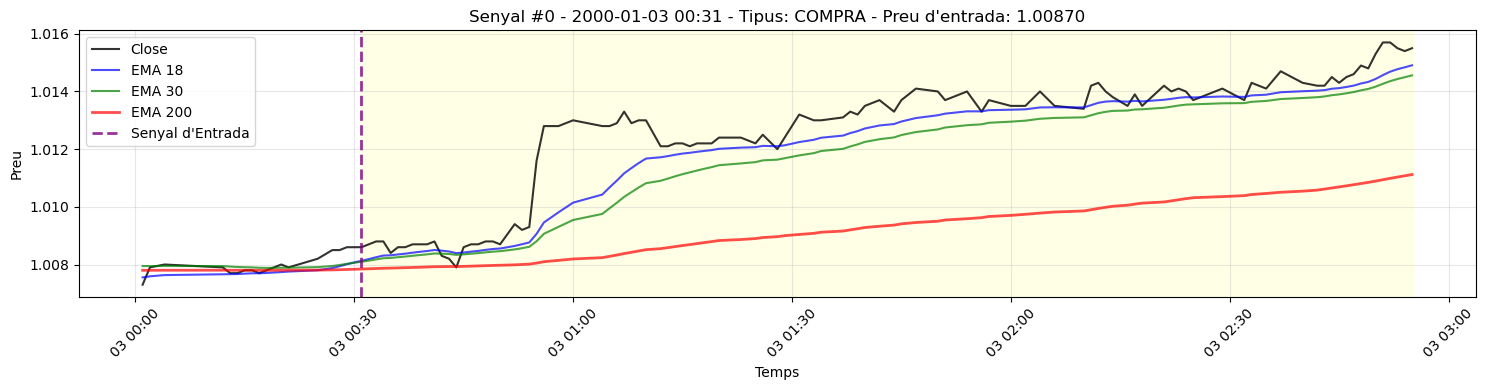

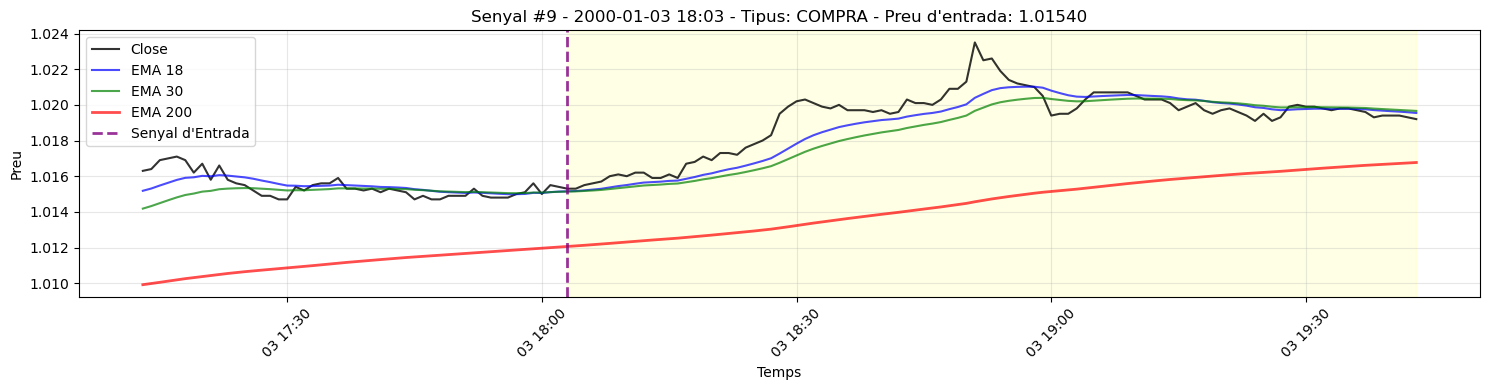

In [4]:
symbol = "EURUSD"; MagicNumber = 1006; realtime = False
strategy_params = load_strategy_parameters(MagicNumber, path_root)
print("PARÀMETRES DEL SISTEMA:")
print(json.dumps(strategy_params, indent=2, ensure_ascii=False))
data = get_strategy(symbol, MagicNumber, path_root, realtime)
display(data.tail(2))
for signal_index in [0,9]:
    plot_signal(data, signal_index, bars_left=50, bars_right=100)